In [34]:
import cv2
import dlib
import imutils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [35]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def extract_facial_landmarks(image_path, shape_predictor):
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    shapes = []
    for rect in rects:
        shape = predictor(gray, rect)
        shape = shape_to_np(shape)
        shapes.append(shape)
    return image, shapes

def extract_non_white_points_weighted_middle(image_path, num_points=68):
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        pixels = np.array(img)
    white_threshold = 245
    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))
    height, width = pixels.shape[:2]
    mid_x_start, mid_x_end = width // 3, 2 * width // 3
    mid_y_start, mid_y_end = height // 3, 2 * height // 3
    middle_grid_coords = []
    other_coords = []
    for x, y in zip(non_white_pixels[1], non_white_pixels[0]):
        if mid_x_start <= x < mid_x_end and mid_y_start <= y < mid_y_end:
            middle_grid_coords.append((x, y))
        else:
            other_coords.append((x, y))
    if len(middle_grid_coords) + len(other_coords) < num_points:
        raise ValueError("Not enough non-white points to sample the desired number of points.")
    middle_weight = 2
    weighted_coords = middle_grid_coords * middle_weight + other_coords
    np.random.seed(0)
    sampled_indices = np.random.choice(len(weighted_coords), size=num_points, replace=False)
    sampled_point_coordinates = [weighted_coords[i] for i in sampled_indices]
    return sampled_point_coordinates

In [36]:
detector = dlib.get_frontal_face_detector()
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(shape_predictor)

image_path1 = '001.jpg'
image1, shapes1 = extract_facial_landmarks(image_path1, shape_predictor)

In [37]:
def calculate_euclidean_distance(shapes1, shapes2):
    if len(shapes1) != len(shapes2):
        raise ValueError("兩組點的數量必須相同。")

    total_distance = 0
    for (x1, y1), (x2, y2) in zip(shapes1, shapes2):
        distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        total_distance += distance

    average_distance = total_distance / len(shapes1)
    return average_distance

In [38]:
def calculate_min_max_avg_distance(shapes1, shapes2):
    all_distances = []
    for point1 in shapes1:
        point1_np = np.array(point1)
        distances = np.sqrt(np.sum((np.array(shapes2) - point1_np) ** 2, axis=1))
        all_distances.append(np.min(distances))

    min_distance = np.min(all_distances)
    max_distance = np.max(all_distances)
    avg_distance = np.mean(all_distances)
    return min_distance, max_distance, avg_distance

In [39]:
def calculate_density(shapes1, shapes2, radius=300):
    density_list = []
    for point1 in shapes1:
        count = sum(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < radius for point2 in shapes2)
        density_list.append(count)
    return density_list

In [40]:
def calculate_correlation(shapes1, shapes2):
    x_coords1, y_coords1 = zip(*shapes1)
    x_coords2, y_coords2 = zip(*shapes2)

    correlation_x = np.corrcoef(x_coords1, x_coords2)[0, 1]
    correlation_y = np.corrcoef(y_coords1, y_coords2)[0, 1]

    return correlation_x, correlation_y

In [41]:
def perform_comparisons(shapes1, shapes2, weights, max_values):
    euclidean_distance = calculate_euclidean_distance(shapes1, shapes2)
    min_distance, max_distance, avg_distance = calculate_min_max_avg_distance(shapes1, shapes2)
    density = calculate_density(shapes1, shapes2)
    correlation_x, correlation_y = calculate_correlation(shapes1, shapes2)

    euclidean_score = max(0, min(100, (max_values['euclidean'] - euclidean_distance) / max_values['euclidean'] * 100))
    min_max_avg_score = max(0, min(100, (max_values['min_max_avg'] - avg_distance) / max_values['min_max_avg'] * 100))
    density_score = max(0, min(100, np.mean(density) / max_values['density'] * 100))
    correlation_score = (correlation_x + correlation_y) / 2 * 50 + 50
    correlation_score = max(0, min(100, correlation_score))


    weighted_average_score = (
        weights["euclidean"] * euclidean_score +
        weights["min_max_avg"] * min_max_avg_score +
        weights["density"] * density_score +
        weights["correlation"] * correlation_score
    )

    return weighted_average_score


In [42]:
weights = {
    "euclidean": 1/4,
    "min_max_avg": 1/4,
    "density": 1/4,
    "correlation": 1/4
}
max_values = {
    "euclidean": np.sqrt((450 - 150) ** 2 + (500 - 250) ** 2),
    "min_max_avg": np.sqrt((450 - 150) ** 2 + (500 - 250) ** 2),
    "density": 30,  
    "correlation": 1  
}

In [43]:
def process_folder(folder_path, shapes1, weights, max_values):
    scores = {}
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        shapes2 = extract_non_white_points_weighted_middle(image_path)
        score = perform_comparisons(shapes1[0], shapes2, weights, max_values)
        scores[image_file] = score
        print(f"Score for {image_file}: {score:.2f}")  
    return scores

folder_path = 'images'  
scores = process_folder(folder_path, shapes1, weights, max_values)
highest_score_image = max(scores, key=scores.get)
highest_score_image_path = os.path.join(folder_path, highest_score_image)



Score for 1.jpg: 39.79
Score for 10.jpg: 32.66
Score for 100.jpg: 31.52
Score for 101.jpg: 34.54
Score for 102.jpg: 39.51
Score for 103.jpg: 25.38
Score for 104.jpg: 36.12
Score for 105.jpg: 39.72
Score for 106.jpg: 25.85
Score for 107.jpg: 31.45
Score for 108.jpg: 32.25
Score for 109.jpg: 20.35
Score for 11.jpg: 38.16
Score for 110.jpg: 28.14
Score for 12.png: 31.32
Score for 13.png: 27.79
Score for 14.jpg: 32.89
Score for 15.png: 23.83
Score for 16.jpg: 45.28
Score for 17.jpg: 35.57
Score for 18.png: 30.26
Score for 19.jpg: 45.43
Score for 2.jpg: 36.66
Score for 20.jpg: 33.21
Score for 21.jpg: 30.35
Score for 22.jpg: 30.56
Score for 23.jpg: 35.77
Score for 24.jpg: 31.68
Score for 25.jpg: 34.98
Score for 26.jpg: 37.81
Score for 27.jpg: 27.08
Score for 28.jpg: 26.04
Score for 29.jpg: 28.09
Score for 3.jpg: 43.09
Score for 30.jpg: 24.00
Score for 31.jpg: 37.36
Score for 32.jpg: 32.12
Score for 33.jpg: 33.44
Score for 34.jpg: 25.53
Score for 35.jpg: 25.24
Score for 36.jpg: 27.60
Score fo

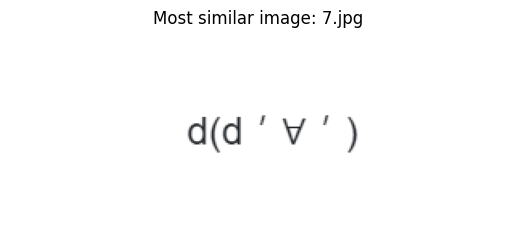

In [44]:
img = Image.open(highest_score_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Most similar image: {highest_score_image}")
plt.show()